## 부탁 드립니다!

본 자료는 패스트캠퍼스 RAG 비법노트 강의에서 유료 강의로 제공되는 자료입니다. 

따라서, 제공된 코드를 사용하여 개발하는 것은 얼마든지 가능합니다만,

**제 3자 에게 무단배포, 웹에 소스코드 게재 및 배포는 금지**하고 있다는 점 부디 양해해 주시기 바랍니다.

개발 및 학습 목적으로만 활용해 주세요. 많은 도움이 되었으면 좋겠습니다. 늘 감사드립니다.

## 환경 설정


In [104]:
from dotenv import load_dotenv

load_dotenv()

True

In [105]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

LangSmith 추적을 하지 않습니다.


## 전체 워크플로우 구성

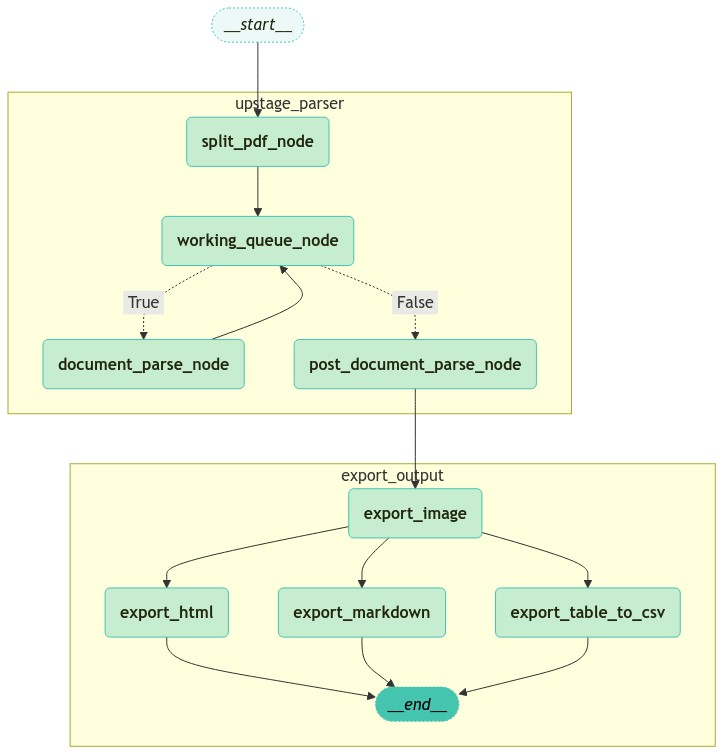

In [106]:
# PDF 파싱과 관련된 필수 모듈들을 임포트합니다
from layoutparse.teddynote_parser import (
    create_upstage_parser_graph,  # Upstage 파서 그래프를 생성하는 함수
    create_export_graph,  # 결과를 내보내는 그래프를 생성하는 함수
)

# 그래프 관련 기본 모듈들을 임포트합니다
from langgraph.graph import StateGraph, END  # 상태 그래프와 종료 상태를 위한 모듈
from layoutparse.state import ParseState  # 파싱 상태를 관리하는 클래스
from langchain_teddynote.graphs import visualize_graph  # 그래프 시각화를 위한 모듈
from langgraph.checkpoint.memory import MemorySaver  # 체크포인트 저장을 위한 모듈

"""
PDF 문서 파싱을 위한 전체 워크플로우를 구성하는 코드입니다.
Upstage 파서와 결과 내보내기 기능을 포함한 파이프라인을 구성합니다.
"""

# Upstage 파서 그래프를 생성합니다 - 배치 크기 30으로 설정하고 상세 로그를 출력합니다
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True
)
# 결과를 마크다운으로 내보내는 그래프를 생성합니다
export_graph = create_export_graph(show_image_in_markdown=True)


# 전체 워크플로우를 담을 부모 그래프를 생성합니다
parent_workflow = StateGraph(ParseState)

# Upstage 파서 노드를 워크플로우에 추가합니다
parent_workflow.add_node("upstage_parser", upstage_parser_graph)
# 결과 내보내기 노드를 워크플로우에 추가합니다
parent_workflow.add_node("export_output", export_graph)

# 파서에서 내보내기로 이어지는 엣지를 추가합니다
parent_workflow.add_edge("upstage_parser", "export_output")

# 워크플로우의 시작점을 Upstage 파서로 설정합니다
parent_workflow.set_entry_point("upstage_parser")

# 메모리 체크포인터를 사용하여 그래프를 컴파일합니다
parent_graph = parent_workflow.compile(checkpointer=MemorySaver())

# 생성된 그래프를 시각화합니다 (내부 구조까지 표시)
visualize_graph(parent_graph, xray=True)

In [107]:
# UUID 모듈을 가져와서 고유 식별자를 생성할 수 있게 합니다
import uuid

# Langchain의 실행 설정을 위한 RunnableConfig를 가져옵니다
from langchain_core.runnables import RunnableConfig

# 그래프 실행 결과를 스트리밍하기 위한 유틸리티 함수를 가져옵니다
from langchain_teddynote.messages import stream_graph

"""
그래프 실행을 위한 설정과 입력값을 준비하고 실행하는 코드입니다.
재귀 제한과 스레드 ID를 설정하여 안정적인 실행을 보장합니다.
"""

# 그래프 실행을 위한 상세 설정을 구성합니다
config = RunnableConfig(
    # 재귀 호출의 최대 깊이를 300으로 제한하여 무한 루프를 방지합니다
    recursion_limit=300,
    # 실행마다 고유한 스레드 ID를 생성하여 독립적인 실행을 보장합니다
    configurable={"thread_id": str(uuid.uuid4())},
)

# 분석할 PDF 파일의 경로를 입력값으로 설정합니다
inputs = {
    # PDF 파일의 실제 경로를 지정합니다
    "filepath": "data/argus-bitumen.pdf",
}

# 설정된 그래프를 스트리밍 방식으로 실행하고 결과를 실시간으로 확인합니다
stream_graph(parent_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 21.67 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21
[ExportMarkdown] 마크다운 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/argus-bitumen.md
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_10.csv
[ExportHTML] HTML 파일이 성공적으로 생성되었습니다: data/argus-bitumen.html
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_0_Index_14.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-BITUMEN_TABLE_Page_1_Index_26.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /Users/teddy/Dev/github/teddynote-parser-v2/data/tables/ARGUS-B

In [108]:
"""
파서에서 추출된 요소들을 확인하고 분석하기 위한 코드입니다.
마지막 30개의 요소 중 5개를 샘플로 확인합니다.
"""

# parent_graph에서 현재 상태를 가져와서 파서가 추출한 요소들을 elements 변수에 저장합니다
elements = parent_graph.get_state(config).values["elements_from_parser"]

# 마지막 30개 요소 중에서 5개만 슬라이싱하여 확인합니다 (디버깅 및 검증 목적)
elements[-30:-25]

[{'category': 'list',
  'content': {'html': "<br><p id='435' data-category='list' style='font-size:16px'>•\t News<br>•\t Prices\t<br>•\t Commentary<br>•\t Data\tand\t\t<br>downloads</p>",
   'markdown': '- •\t News\n- •\t Prices\t\n- •\t Commentary\n- •\t Data\tand\t\t\n- downloads\n',
   'text': '•\t News\n•\t Prices\t\n•\t Commentary\n•\t Data\tand\t\t\ndownloads'},
  'coordinates': [{'x': 0.5489, 'y': 0.301},
   {'x': 0.6592, 'y': 0.301},
   {'x': 0.6592, 'y': 0.3881},
   {'x': 0.5489, 'y': 0.3881}],
  'id': 435,
  'page': 20},
 {'base64_encoding': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIALIBSAMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw

## 중간에 모듈 삽입

In [109]:
# UUID 모듈을 가져와서 고유 식별자를 생성하기 위해 임포트합니다
import uuid

# Langchain의 실행 설정을 위한 RunnableConfig를 가져옵니다
from langchain_core.runnables import RunnableConfig

# 그래프 실행 결과를 스트리밍하기 위한 유틸리티 함수를 가져옵니다
from langchain_teddynote.messages import stream_graph

"""
그래프 실행을 위한 설정과 입력값을 준비하는 코드입니다.
재귀 제한과 스레드 ID를 설정하여 안정적인 실행을 보장합니다.
"""

# RunnableConfig를 사용하여 실행 설정을 구성합니다
config = RunnableConfig(
    # 재귀 호출의 최대 깊이를 300으로 제한하여 무한 루프를 방지합니다
    recursion_limit=300,
    # UUID를 사용하여 각 실행마다 고유한 스레드 ID를 생성합니다
    configurable={"thread_id": str(uuid.uuid4())},
)

# 분석할 PDF 파일의 경로를 입력값으로 설정합니다
inputs = {
    # PDF 파일의 실제 경로를 지정합니다
    "filepath": "data/argus-bitumen.pdf",
}

# 설정된 그래프를 스트리밍 방식으로 실행하여 결과를 실시간으로 확인합니다
stream_graph(upstage_parser_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 20.73 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21


In [111]:
# 이전 상태의 그래프 값을 가져오는 함수입니다
previous_state = upstage_parser_graph.get_state(config).values

# 파서가 추출한 요소들 중 마지막 30개 요소에서 5개만 슬라이싱하여 확인합니다 (디버깅 목적)
previous_state["elements_from_parser"][-30:-25]

[{'category': 'list',
  'content': {'html': "<br><p id='435' data-category='list' style='font-size:16px'>•\t News<br>•\t Prices\t<br>•\t Commentary<br>•\t Data\tand\t\t<br>downloads</p>",
   'markdown': '- •\t News\n- •\t Prices\t\n- •\t Commentary\n- •\t Data\tand\t\t\n- downloads\n',
   'text': '•\t News\n•\t Prices\t\n•\t Commentary\n•\t Data\tand\t\t\ndownloads'},
  'coordinates': [{'x': 0.5489, 'y': 0.301},
   {'x': 0.6592, 'y': 0.301},
   {'x': 0.6592, 'y': 0.3881},
   {'x': 0.5489, 'y': 0.3881}],
  'id': 435,
  'page': 20},
 {'base64_encoding': '/9j/2wCEAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgoBAgICAgICBQMDBQoHBgcKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCv/AABEIALIBSAMBIgACEQEDEQH/xAGiAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgsQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw

번역 모듈 추가 예시

In [112]:
# Langchain의 프롬프트 템플릿을 사용하기 위한 임포트
from langchain_core.prompts import PromptTemplate

# Pydantic 모델 정의를 위한 임포트
from pydantic import Field, BaseModel

# 출력 파서 관련 임포트
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

# OpenAI 챗봇 모델 사용을 위한 임포트
from langchain_openai import ChatOpenAI

# 커스텀 모델 설정을 위한 임포트
from langchain_teddynote.models import get_model_name, LLMs

# GPT-4 모델명을 가져옵니다
MODEL_NAME = get_model_name(LLMs.GPT4)


# 번역된 텍스트를 담기 위한 Pydantic 모델 클래스 정의
class TranslatedText(BaseModel):
    # 번역된 텍스트를 저장할 필드 정의
    translated_text: str = Field(description="The translated text of the given text")


# Pydantic 모델을 사용하는 출력 파서 생성
output_parser = PydanticOutputParser(pydantic_object=TranslatedText)
# 번역을 위한 프롬프트 템플릿 정의
prompt = PromptTemplate.from_template(
    """You are a translation expert. Translate the <given_text> into Korean.
[IMPORTANT] Keep the <given_text>'s markdown format.

###

<given_text>
{text}
</given_text>"""
)
# ChatGPT 모델 인스턴스 생성 및 구조화된 출력 설정
llm = ChatOpenAI(model=MODEL_NAME, temperature=0).with_structured_output(TranslatedText)

# 프롬프트와 LLM을 연결하는 체인 생성
chain = prompt | llm


"""
번역 모듈을 추가하는 함수입니다.
주어진 상태(state)의 텍스트 요소들을 한국어로 번역합니다.

Args:
    state (ParseState): 파싱된 상태 객체

Returns:
    dict: 번역된 요소들이 포함된 상태 딕셔너리
"""


def add_translation_module(state: ParseState):
    # 번역이 필요한 요소들을 담을 리스트 생성
    translated_elements = []
    # 상태에서 번역이 필요한 카테고리의 요소들만 선택
    for element in state["elements_from_parser"]:
        # 번역이 필요한 카테고리들을 지정
        if element["category"] in [
            "paragraph",
            "index",
            "heading1",
            "header",
            "footer",
            "caption",
            "list",
            "footnote",
        ]:
            translated_elements.append(element)

    # 배치 크기 설정 (한 번에 처리할 요소 수)
    BATCH_SIZE = 50
    # 번역 결과를 저장할 리스트
    all_translated_results = []

    # 배치 단위로 번역 처리
    for i in range(0, len(translated_elements), BATCH_SIZE):
        # 현재 배치의 요소들 추출
        batch = translated_elements[i : i + BATCH_SIZE]
        # 배치 데이터 준비
        batch_data = [{"text": text["content"]["markdown"]} for text in batch]
        # 재시도 횟수 설정
        trial = 3
        while trial > 0:
            try:
                # 배치 번역 실행
                batch_results = chain.batch(batch_data)
                break
            except Exception as e:
                print(e)
                trial -= 1
                continue
        # 번역 결과 출력
        for result in batch_results:
            print(result)
        # 전체 결과 리스트에 현재 배치 결과 추가
        all_translated_results.extend(batch_results)

    # 번역된 텍스트를 원본 요소에 업데이트
    for i, result in enumerate(all_translated_results):
        translated_elements[i]["content"]["markdown"] = result.translated_text

    # 업데이트된 상태 반환
    return {"elements_from_parser": state["elements_from_parser"]}

In [113]:
# 이전 상태의 텍스트를 번역 모듈을 통해 번역합니다
translated_state = add_translation_module(previous_state)

# 번역된 결과에서 마지막 30개 요소 중 앞의 5개 요소만 확인합니다 (디버깅/검증 목적)
translated_state["elements_from_parser"][-30:-25]

translated_text='유럽, 아프리카, 중동 및 아시아 태평양 가격 및 논평\nArgus 아스팔트 보고서 포함'
translated_text='요약'
translated_text='비투멘 가격이 유럽 대부분에서 상승했으며, 북부에서 공급이 긴축되고 연료유 가격이 상승했습니다. 반면 아시아에서는 수요 약세가 시장에 계속 영향을 미치고 있으며, 싱가포르와 한국의 가격 모두 주간 하락했습니다.'
translated_text='프랑스의 두 정유소에서의 중단이 북서 유럽의 비투멘 공급을 계속 압박하고 있으며, 이는 로테르담 및 발트해 화물 차별을 로테르담 고황 함유 연료유(HSFO) 바지선의 fob 가격으로 끌어올리는 데 도움을 주고 있습니다.'
translated_text='지중해 아스팔트 시장 활동과 수요 수준은 많은 유럽 시장에서 따뜻한 날씨와 함께 상승하기 시작했으며, 이는 지역 HSFO 가격 상승과 함께 일부 시장에서 국내 트럭 가격을 끌어올리는 요인이 되었습니다.'
translated_text='대부분의 사하라 이남 아프리카 시장의 가격 수준은 대체로 안정적이었으나, 서아프리카 터미널로의 화물 가치는 급격히 상승했으며, 동아프리카로의 컨테이너 운송에 대한 운임은 일부 하락했습니다.'
translated_text='싱가포르 아스팔트 가격이 하락세를 보였으며, 동남아시아 시장은 수요처 부족이 계속되고 있어 4월 선적 화물을 찾는 구매자가 제한적이었다. 여러 대형 석유 회사들은 여전히 판매되지 않은 4월 선적 물량을 보유하고 있었고, 일부는 구매자를 찾기 위해 Argus Open Markets (AOM) 플랫폼에 나타났다.'
translated_text='# 아르구스 비투멘'
translated_text='문제 24-12 | 금요일 2024년 3월 22일'
translated_text='가격'
translated_text='북해 날짜 기준 대 로테르담 국내'
translated_text='$/bl'
translated_text='목차'
translated

KeyboardInterrupt: 

ContextualizedText 모듈 예시

In [80]:
# LangChain의 핵심 컴포넌트들을 임포트합니다
from langchain_core.prompts import PromptTemplate
from pydantic import Field, BaseModel
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# GPT-4 모델을 사용하기 위한 모델명을 가져옵니다
MODEL_NAME = get_model_name(LLMs.GPT4)


# 문맥화된 텍스트를 위한 Pydantic 모델을 정의합니다
class ContextualizedText(BaseModel):
    """
    문맥화된 텍스트를 담는 Pydantic 모델입니다.
    주어진 텍스트에 추가적인 문맥 정보를 포함시킵니다.
    """

    contextualized_text: str = Field(
        description="The more contextualized text from the given text"
    )


# 출력 파서를 설정합니다
output_parser = PydanticOutputParser(pydantic_object=ContextualizedText)

# 프롬프트 템플릿을 정의합니다
prompt = PromptTemplate.from_template(
    """You are given a text. Your mission is to make the text more contextualized.
You can add more information to the <given_text> from the background information.
First, you need to find the information that is needed to be explained in the <given_text>.
Then, you need to add the information to the <given_text>. 
The language of the <given_text> is same as <given_text>'s language.

Final output should be like this:
<final_text> = <contextualized_text> + <given_text>

[IMPORTANT] Keep the text's markdown format.

###

<background_information>
{background_information}
</background_information>

<given_text>
{text}
</given_text>"""
)

# ChatGPT 모델을 초기화하고 구조화된 출력을 설정합니다
llm = ChatOpenAI(model=MODEL_NAME, temperature=0).with_structured_output(
    ContextualizedText
)

# 프롬프트와 LLM을 체인으로 연결합니다
chain = prompt | llm


# 텍스트 문맥화 함수를 정의합니다
def contextualize_text(state: ParseState):
    """
    주어진 상태의 텍스트를 문맥화하는 함수입니다.
    각 페이지별로 요소들을 그룹화하고 배치 처리하여 문맥을 추가합니다.

    Args:
        state (ParseState): 처리할 파싱 상태

    Returns:
        dict: 문맥화된 텍스트가 포함된 상태
    """
    # 페이지별로 요소들을 그룹화합니다
    elements_by_page = {}
    for element in state["elements_from_parser"]:
        if element["category"] in [
            "paragraph",
            "index",
            "heading1",
            "header",
            "footer",
            "caption",
            "list",
            "footnote",
        ]:
            page = element["page"]
            if page not in elements_by_page:
                elements_by_page[page] = []
            elements_by_page[page].append(element)

    # 배치 크기를 설정하고 페이지별로 처리합니다
    BATCH_SIZE = 10
    for page, elements in elements_by_page.items():
        for i in range(0, len(elements), BATCH_SIZE):
            batch = elements[i : i + BATCH_SIZE]
            # 배치의 모든 텍스트를 배경 정보로 결합합니다
            background = " ".join([elem["content"]["text"] for elem in batch])
            batch_data = [
                {
                    "text": elem["content"]["markdown"],
                    "background_information": background,
                }
                for elem in batch
            ]

            # 배치 처리를 수행하고 결과를 출력합니다
            contextualized_results = chain.batch(batch_data)
            for elem, cr in zip(batch, contextualized_results):
                print("[Original Text]")
                print(elem["content"]["markdown"])
                print("-" * 100)
                print("[Contextualized Text]")
                print(cr.contextualized_text)
                print("-" * 100)

            # 문맥화된 결과로 원본 요소를 업데이트합니다
            for elem, result in zip(batch, contextualized_results):
                elem["content"]["markdown"] = result.contextualized_text

    # 업데이트된 상태를 반환합니다
    return {"elements_from_parser": state["elements_from_parser"]}

In [81]:
# 문맥화된 텍스트를 생성하기 위해 이전 상태를 contextualize_text 함수에 전달합니다
contextualized_state = contextualize_text(previous_state)

# 문맥화된 결과의 마지막 30개 요소 중 5개를 확인하기 위해 슬라이싱을 수행합니다
contextualized_state["elements_from_parser"][-30:-25]

[Original Text]
유럽, 아프리카, 중동 및 아시아-태평양 가격 및 논평  
아르구스 아스팔트 보고서 포함  
유럽의 비트멘 가격이 상승하고 있으며, 이는 북부 지역에서 공급이 긴축되고 연료유 가격이 상승했기 때문입니다. 특히, 프랑스의 두 개 정유소에서 발생한 중단 사태는 북서 유럽의 비트멘 공급을 더욱 압박하고 있으며, 이로 인해 로테르담과 발트해 화물의 차별화가 높아지고 있습니다. 이러한 공급 압박은 비트멘 가격 상승에 기여하고 있습니다.  
반면 아시아에서는 수요가 약세를 보이며 시장에 부정적인 영향을 미치고 있습니다. 싱가포르와 한국의 가격은 모두 하락했습니다. 아시아 시장에서는 특히 제한된 구매자만이 4월 적재 화물을 찾고 있으며, 여러 대형 석유 회사들이 여전히 판매되지 않은 4월 적재 물량을 보유하고 있습니다. 이들은 아르구스 오픈 마켓(AOM) 플랫폼에서 구매자를 찾기 위해 나타나기도 했습니다.  
지중해 비트멘 시장의 활동과 수요는 따뜻한 날씨로 인해 증가하기 시작했으며, 이는 지역 HSFO 가격 상승과 함께 일부 시장에서 국내 트럭 가격을 끌어올리고 있습니다. 아프리카의 대부분 시장에서는 가격이 안정세를 보이고 있지만, 서부 아프리카 터미널로의 화물 가치는 급등하고 있으며, 동부 아프리카로의 컨테이너 운송에 대한 운임은 하락세를 보이고 있습니다.  
비트멘 가격은 유럽 전역에서 상승세를 보이고 있으며, 이는 공급이 긴축되고 연료유 가격이 상승하는 것과 관련이 있습니다. 특히, 프랑스의 두 개 정유소에서의 중단 사태는 북서 유럽의 비트멘 공급을 더욱 압박하고 있으며, 이로 인해 로테르담과 발트해 화물의 차별화가 높아지고 있습니다. 이러한 공급 압박은 비트멘 가격 상승에 기여하고 있습니다.  
아시아에서는 수요가 약세를 보이며 시장에 부정적인 영향을 미치고 있습니다. 싱가포르와 한국의 가격은 모두 하락했습니다. 아시아 시장에서는 특히 제한된 구매자만이 4월 적재 화물을 찾고 있으며, 여러 대형 석유 회사들이 여전히 판매되지 않은 4월

KeyboardInterrupt: 

## 그래프에 신규 노드 추가

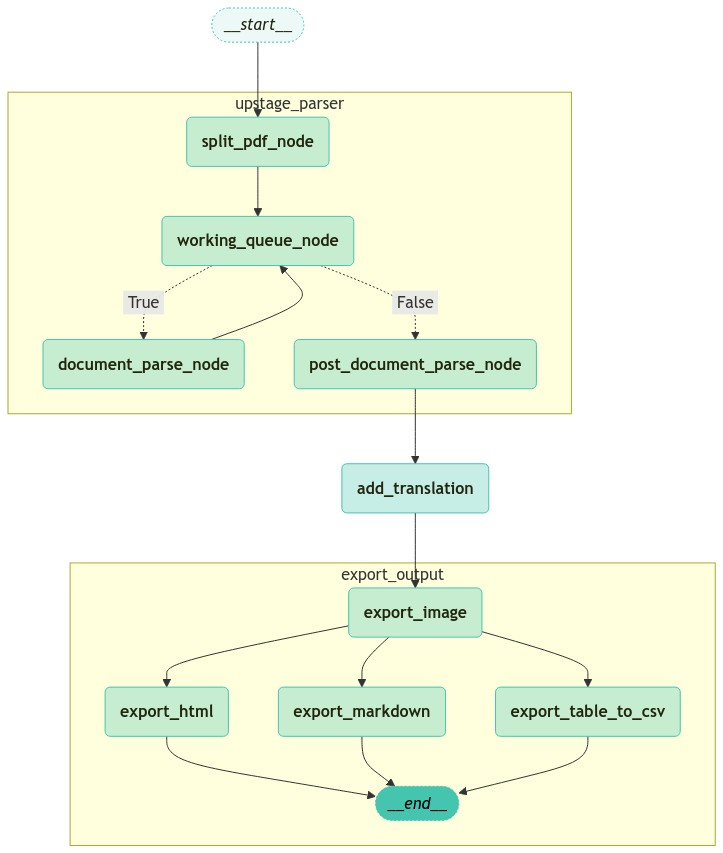

In [114]:
# 레이아웃 파서와 그래프 생성에 필요한 모듈들을 임포트합니다
from layoutparse.teddynote_parser import (
    create_upstage_parser_graph,  # 업스테이지 파서 그래프를 생성하는 함수
    create_export_graph,  # 결과를 내보내는 그래프를 생성하는 함수
)

# 그래프 관련 기본 모듈들을 임포트합니다
from langgraph.graph import StateGraph, END  # 상태 그래프와 종료 상태를 위한 클래스
from layoutparse.state import ParseState  # 파싱 상태를 관리하는 클래스
from langchain_teddynote.graphs import visualize_graph  # 그래프를 시각화하는 함수
from langgraph.checkpoint.memory import MemorySaver  # 체크포인트 저장을 위한 클래스

"""
이 코드는 PDF 문서를 파싱하고 번역하는 워크플로우를 구성하는 그래프를 생성합니다.
각 노드는 특정 작업을 수행하며, 엣지는 작업들 간의 흐름을 정의합니다.
"""

# 업스테이지 파서 그래프를 생성합니다 (배치 크기 30으로 설정)
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True
)
# 결과를 마크다운으로 내보내는 그래프를 생성합니다
export_graph = create_export_graph(show_image_in_markdown=True)


# ParseState를 기반으로 하는 부모 워크플로우 그래프를 생성합니다
parent_workflow = StateGraph(ParseState)

# 각 작업을 수행하는 노드들을 워크플로우에 추가합니다
parent_workflow.add_node("upstage_parser", upstage_parser_graph)  # PDF 파싱 노드
parent_workflow.add_node("add_translation", add_translation_module)  # 번역 노드
# parent_workflow.add_node("contextualize_text", contextualize_text)  # 문맥화 노드 (현재 비활성화)
parent_workflow.add_node("export_output", export_graph)  # 결과 내보내기 노드

# 노드들 간의 연결을 정의합니다
parent_workflow.add_edge("upstage_parser", "add_translation")  # 파싱 -> 번역
# parent_workflow.add_edge("upstage_parser", "contextualize_text")  # 파싱 -> 문맥화 (현재 비활성화)
parent_workflow.add_edge("add_translation", "export_output")  # 번역 -> 내보내기

# 워크플로우의 시작점을 업스테이지 파서로 설정합니다
parent_workflow.set_entry_point("upstage_parser")

# 메모리 체크포인터를 사용하여 그래프를 컴파일합니다
parent_graph = parent_workflow.compile(checkpointer=MemorySaver())

# 생성된 그래프를 시각화합니다 (내부 구조도 함께 표시)
visualize_graph(parent_graph, xray=True)

In [115]:
# UUID 모듈을 임포트하여 고유한 식별자를 생성할 수 있게 합니다
import uuid

# Langchain의 실행 설정을 위한 RunnableConfig를 임포트합니다
from langchain_core.runnables import RunnableConfig

# 그래프 실행 결과를 스트리밍하기 위한 함수를 임포트합니다
from langchain_teddynote.messages import stream_graph

"""
이 코드는 PDF 파싱 워크플로우를 실행하기 위한 설정과 입력값을 정의하고
실제 실행을 담당하는 부분입니다.
"""

# 워크플로우 실행을 위한 설정을 구성합니다
# recursion_limit는 재귀 호출의 제한을, thread_id는 실행 추적을 위한 고유 ID를 설정합니다
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# 워크플로우에 필요한 입력값을 정의합니다
# 여기서는 분석할 PDF 파일의 경로만 지정합니다
inputs = {
    "filepath": "data/argus-bitumen.pdf",
}

# stream_graph 함수를 호출하여 설정된 워크플로우를 실행하고 결과를 스트리밍합니다
stream_graph(parent_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 21 Pages.
[SplitPDFNode] 분할 PDF 생성: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Start Parsing: data/argus-bitumen_0000_0020.pdf
[DocumentParseNode] Finished Parsing in 19.25 seconds
[PostDocumentParseNode] Total Post-processed Elements: 465
[PostDocumentParseNode] Total Cost: $0.21
translated_text='유럽, 아프리카, 중동 및 아시아-태평양 가격 및 논평\nArgus 아스팔트 보고서 포함'
translated_text='요약'
translated_text='비투멘 가격이 유럽 대부분에서 상승했으며, 북부에서 공급이 긴축되고 연료유 가격이 상승했습니다. 반면 아시아에서는 수요 약세가 시장에 계속 영향을 미치고 있으며, 싱가포르와 한국의 가격 모두 주간 하락했습니다.'
translated_text='프랑스의 두 정유소에서의 중단이 북서 유럽의 비투멘 공급을 계속 압박하고 있으며, 이는 로테르담과 발트해 화물의 차이를 로테르담 고황 함유 연료유(HSFO) 바지선의 fob 로테르담 가격으로 끌어올리는 데 도움을 주고 있습니다.'
translated_text='지중해 아스팔트 시장 활동과 수요 수준은 많은 유럽 시장에서 따뜻한 날씨와 함께 상승하기 시작했으며, 이는 지역 HSFO 가격 상승과 함께 일부 시장에서 국내 트럭 가격을 끌어올리는 요인이 되었습니다.'
translated_text='대부분의 사하라 이남 아프리카 시장의 가격 수준은 대체로 안정적이었으나, 서아프리카 터미널로의 화물 가치는 급격히 상승했으며, 동아프리카로의 컨테이너 운송에 대한 운임은 일부 하락했습니다.'
translated_text='싱가포르 아스팔트 가격이 하락세를 보였으며, 동남아시아 시장은 수